In [84]:
import json
import gzip
import copy
import re
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import fisher_exact
from wordcloud import WordCloud

In [85]:
DO_ID_PATH_JSON = 'data/do/do_id.json'
DO_ID_PATH_OBO = 'data/do/doid.obo.txt'
PUBMED_PATH = 'data/do/human_pubmed.tab'
UNI2DO_PATH = 'data/do/uniprot_do.json'
DO_HUMAN = 'data/do/do_human.csv'

In [37]:
# Parse the disease ontology
do = {}  # { do_id : do_object }
obj = {}  # { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True }
with open(DO_ID_PATH_OBO) as f:
    for line in f:
        line = line.strip().split(": ")
        
        if line and len(line) == 2:
            k, v = line
            if k == "id" and v.startswith("DOID:"):
                obj["id"] = v.split(":")[1]
            elif k == 'def':
                obj['descr'] = v.split('"')[1] 
            elif k == "xref" and "OMIM" in v:
                obj["omim"] = v.split(":")[1]
            elif k == "name":
                obj["name"] = v
            elif k == "is_a":
                obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
            elif k == "is_obsolete":
                obj["is_obsolete"] = True
        else:
            if obj.get("id") and not obj.get("is_obsolete"):
                do[obj["id"]] = obj
            obj = {}
            
name_do = {}
for k, v in do.items():
    name_do.setdefault(v['name'], k)

In [70]:
do_df = pd.DataFrame(do).transpose()
do_df.head()

,id,name,descr,is_a,omim
0001816,0001816,angiosarcoma,A vascular cancer that derives_from the cells ...,[175],NaN
0002116,0002116,pterygium,A corneal disease that is characterized by a t...,[10124],NaN
0014667,0014667,disease of metabolism,A disease that involving errors in metabolic p...,[4],NaN
0040001,0040001,shrimp allergy,A crustacean allergy that has_allergic_trigger...,[0060524],NaN
0040002,0040002,aspirin allergy,A drug allergy that has_allergic_trigger acety...,[0060500],NaN


In [38]:
pubmed = pd.read_table(PUBMED_PATH, sep = '\t', dtype=str) 
pubmed.head()

,Entry,Entry name,PubMed ID
0,Q96IY4,CBPB2_HUMAN,1939207; 14702039; 15057823; 15489334; 1057498...
1,P22362,CCL1_HUMAN,2809212; 2212659; 14702039; 15489334; 15340161...
2,Q8NCR9,CLRN3_HUMAN,17974005; 15164054; 15489334; 23033978
3,Q8IUK8,CBLN2_HUMAN,14702039; 12975309; 15489334
4,Q9BX69,CARD6_HUMAN,15489334; 22814378; 23186163


In [16]:
uniprot_pmid = {}
for n, i in enumerate(pubmed['PubMed ID'][pubmed['PubMed ID'].isna() == False].values):
    ids = i.strip().split('; ')
    for key in ids:
        uniprot_pmid.setdefault(key, []).append(pubmed.loc[n, 'Entry'])
        
pmids = list(uniprot_pmid.keys())
diseases = {}  # { uniprot_id : list_of_diseases }
URL = "https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds"
for i in tqdm(range(0, len(pmids), 8)):
    params = {"articleIds": ",".join(["MED:{}".format(pmid) for pmid in pmids[i:min(i + 8, len(pmids))]]), "type": "Diseases",
              "section"   : "Abstract", "format": "JSON"}
    r = requests.get(URL, params=params)
    obj = json.loads(r.text)
    for ele in obj:
        for annotation in ele.get("annotations"):
            for uniprot_id in uniprot_pmid[ele["extId"]]:
                if annotation["exact"] in name_do.keys():
                    DOID = name_do[annotation["exact"]]
                    diseases.setdefault(uniprot_id, set()).add(DOID)
diseases = {k: list(v) for k, v in diseases.items()}
diseases

In [83]:
do_human_df = pd.merge(left=do_human, right=do_df, how='inner', left_on='do_id', right_on='id').iloc[:, [0, 1, 3, 4]]
do_human_df.sort_values(by=['entry_ac', 'do_id']).head()
do_human_df.to_csv('data/do/do_human.csv', sep='\t')

(49311, 4)
(49311, 2)


In [78]:
with open(UNI2DO_PATH) as file:
    do_human_dict = json.load(file)

do_human = []
for key in do_human_dict.keys():
    for ids in do_human_dict[key]:
        do_human.append([key, ids])
do_human = pd.DataFrame(do_human, columns=['entry_ac', 'do_id'])
do_human.sort_values(by=['entry_ac', 'do_id']).head()

,entry_ac,do_id
21824,A0A075B6H7,0050460
21822,A0A075B6H7,0060058
21825,A0A075B6H7,0080322
21821,A0A075B6H7,1240
21823,A0A075B6H7,12858


In [331]:
do_human = pd.read_table('data/do/do_human.csv', index_col=[0], dtype=str).sort_values(by=['entry_ac', 'do_id'])
do_original = pd.read_table('data/do/do_original.csv', index_col = [0], dtype=str)

,entry_ac,do_id,name,descr
38599,A0A075B6H7,0050460,Wolf-Hirschhorn syndrome,A chromosomal deletion syndrome that is charac...
21442,A0A075B6H7,0060058,lymphoma,A hematologic cancer that affects lymphocytes ...
24090,A0A075B6H7,0080322,polycystic kidney disease,NaN
19851,A0A075B6H7,1240,leukemia,A cancer that affects the blood or bone marrow...
35045,A0A075B6H7,12858,Huntington's disease,A neurodegenerative disease that has_material_...


### ENRICHMENT DO

In [428]:
# Parse the disease ontology
do = {}  # { do_id : do_object }
obj = {}  # { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True }
with open(DO_ID_PATH_OBO) as f:
    for line in f:
        line = line.strip().split(": ")
        
        if line and len(line) == 2:
            k, v = line
            if k == "id" and v.startswith("DOID:"):
                obj["id"] = v.split(":")[1]
            elif k == 'def':
                obj['descr'] = v.split('"')[1] 
            elif k == "xref" and "OMIM" in v:
                obj["omim"] = v.split(":")[1]
            elif k == "name":
                obj["name"] = v
            elif k == "is_a":
                obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
            elif k == "is_obsolete":
                obj["is_obsolete"] = True
        else:
            if obj.get("id") and not obj.get("is_obsolete"):
                do[obj["id"]] = obj
            obj = {}

ontology = pd.DataFrame(do).transpose()
ontology.columns= ['do_id', 'name', 'descr', 'is_a', 'omim']
ontology.is_a[ontology.is_a.isna()] = None
ontology.to_csv('data/do/do_ontology.csv', sep='\t')
def f(x):
    if type(x) == list:
        return '; '.join(x)
    
ontology.is_a = ontology.is_a.map(f)
ontology.to_csv('data/do/do_ontology.csv', sep='\t')
ontology.head(50)

,do_id,name,descr,is_a,omim
0001816,0001816,angiosarcoma,A vascular cancer that derives_from the cells ...,175,NaN
0002116,0002116,pterygium,A corneal disease that is characterized by a t...,10124,NaN
0014667,0014667,disease of metabolism,A disease that involving errors in metabolic p...,4,NaN
0040001,0040001,shrimp allergy,A crustacean allergy that has_allergic_trigger...,0060524,NaN
0040002,0040002,aspirin allergy,A drug allergy that has_allergic_trigger acety...,0060500,NaN
0040003,0040003,benzylpenicillin allergy,A beta-lactam allergy that has_allergic_trigge...,0060519,NaN
0040004,0040004,amoxicillin allergy,A beta-lactam allergy that has_allergic_trigge...,0060519,NaN
0040005,0040005,ceftriaxone allergy,A cephalosporin allergy that has_allergic_trig...,0040021,NaN
0040006,0040006,carbamazepine allergy,A drug allergy that has_allergic_trigger carba...,0060500,NaN
0040007,0040007,abacavir allergy,A drug allergy that has_allergic_trigger abaca...,0060500,NaN


In [333]:
"""
To retrieve the GO that are parents, we cycle over ontology["graphs"][0]["edges"] which is a list of dictionary.
Every dictionary is about a GO id (sub) with a relation (pred) with another GO (obj).
We create a dictionary (parents) with as keys the sons and as values the parents. 
"""
def get_parents(ontology):
    return ontology.is_a[ontology.is_a.isna() == False].to_dict()

"""
Here we cycle over the nodes to obtain a dictionary of GO_id with as value a description.  
- ontology["graphs"][0]["nodes"] is a list of dictionary with dict_keys(['id', 'meta', 'type', 'lbl'])
- ontology["graphs"][0]["nodes"][1]['lbl'] is the value (e.g: "endocytosed synaptic vesicle processing via endosome")
"""
def get_labels(ontology):
    return ontology['name'].to_dict()

"""
Build an ancestors dictionary with as key an GO_id and as value a list of GO_id which are the ancestors of the key.
Return ancestors = {GO_id : list of ancestor GO_ids}
"""
def get_ancestors(ontology):
    nodes = get_labels(ontology).keys()
    parents = get_parents(ontology)
    ancestors = {}
    for node in nodes:
        node_ancestors = []
        node_parents = parents.get(node)
        # Loop parent levels until no more parents
        while node_parents:
            node_ancestors.extend(node_parents)
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        ancestors[node] = node_ancestors
    return ancestors

"""
Build a dictionary for the children (similar to the ancestors one)
Return {node : list_of_children}, leaf terms are not keys.
"""
def get_children(ontology):
    ancestors = get_ancestors(ontology)
    children = {}  
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children

"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Identify nodes with no predecessors
    nodes, parents = ontology.do_id, get_parents(ontology)
    roots = set(nodes) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in nodes:
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth

"""
Perform Fisher test. An Odd-Ratio above 77 tells us the GO prefers the first dataframe (p-value < 0.05), 
while an Odd-Ratio under 0.013 tells us the GO prefers the second dataframe.
Return a Dataframe with index the GO and values the Odd-Ratio and the p-value.
"""
def fisher_test(df1, df2, col_name_go = 'go_id'):
    
    # Inint dict
    results = {}
    
    # Get the number of occurrances of the GO counts
    dict1, dict2 = dict(df1[col_name_go].value_counts()), dict(df2[col_name_go].value_counts())
    
    # Compute the intersaction of the GO terms
    key_intersection = set(dict1.keys()).intersection(set(dict2.keys()))
    
    for key in key_intersection:
        ### 1. Set frequencies
        # Number of occurrences of the specific GO term in DF1   
        tp = dict1[key]
        # Number of occurrences of the specific GO term in DF2
        tn = dict2[key]
        # Number of GO terms that are different from the specific one in DF1
        fp = sum(dict1.values()) - tp
        # Number of GO terms that are different from the specific one in DF2
        fn = sum(dict2.values()) - tn
        # 2. Perform Fisher Exact Test
        fisher_results = fisher_exact([[tp, tn],[fp, fn]])
        # 3. Save results
        results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})
    
    # Return the DataFrame
    return pd.DataFrame(results).transpose()

"""
Function that assign to every GO terms the minimum p-value between its own p-value and the p-values of their children. 
"""
def transmit_pvalue(enrichment, ontology):
    # 1. Get the children of every GO term
    children_dict = get_children(ontology)
    # 2. For every GO in our enrichment dataset we assign to it the minimum p-value of its children 
    for go_id in enrichment.index:
        # Check if the GO term has child
        if children_dict.get(go_id):
            # Retrieve the set of the p-values of all its children
            pvalues = enrichment['p-value'][enrichment.index.isin(children_dict[go_id])]
            # Check we have some children in the dataset. Otherwise we have an empy set 'pvalues'
            if list(pvalues.values):
                # Check if the mimimum pvalue is actually lower than the ancestor one
                min_pvalue = pvalues.min()
                if min_pvalue < enrichment['p-value'][enrichment.index == go_id].values[0]:
                    # If all the conditions are True we assign the minimum pvalue
                    enrichment['p-value'][enrichment.index == go_id] = min_pvalue
    return enrichment
        
    

"""
Pipeline for the enrichment test. Take as input two dataframe and the onotlogy file.
Return a Dataframe with as index the GO_ids and values:
1. the p-value and Odd-Ration of the Fisher exact test,
2. the depth computed from the ontology file
3. the description of the GO_ids
"""
def enrich(df1, df2, ontology, col_name_go = 'go_id', col_name_descr='go_descr'):
    # 1. Get Fisher results
    df = fisher_test(df1, df2, col_name_go=col_name_go)
    # 2. Get Depth
    depth = get_depth(ontology)
    # 4. Update dataframe
    labels_, depth_ = [], []
    for go_id in df.index:
        labels_.append(ontology[col_name_descr][ontology[col_name_go] == go_id].values[0])
        depth_.append(depth[go_id])
    df['depth'] = depth_
    df[col_name_descr] = labels_
    # 5. Return dataframe 
    return df

"""
Filter the enrich dataframe by taking out GO_terms with high p-value or high depth
"""
def enrich_filter(df, max_pvalue=0.05, max_depth=5):
    df_filter = df[(df['p-value'] < max_pvalue) & (df['depth'] <= max_depth)]
    df_filter['score'] = np.log(1/df['p-value'])
    return df_filter
     
"""
Create the word cloud of the description of the enriched dataframe, using as frequencies the inverse of p-value  
"""
def word_cloud(df, col_name, col_score, *args, **kwargs):
    return WordCloud(*args, **kwargs).generate_from_frequencies({
        row[col_name]: row[col_score] for i, row in df.iterrows()
    })

In [387]:
ontology.head(100)

,do_id,name,descr,is_a,omim
0001816,0001816,angiosarcoma,A vascular cancer that derives_from the cells ...,['175'],NaN
0002116,0002116,pterygium,A corneal disease that is characterized by a t...,['10124'],NaN
0014667,0014667,disease of metabolism,A disease that involving errors in metabolic p...,['4'],NaN
0040001,0040001,shrimp allergy,A crustacean allergy that has_allergic_trigger...,['0060524'],NaN
0040002,0040002,aspirin allergy,A drug allergy that has_allergic_trigger acety...,['0060500'],NaN
...,...,...,...,...,...
0040094,0040094,autoimmune glomerulonephritis,An autoimmune disease of urogenital tract that...,['0060049'],NaN
0040095,0040095,autoimmune cardiomyopathy,An autoimmune disease of cardiovascular system...,"['0060051', '114']",NaN
0040096,0040096,autoimmune atherosclerosis,An autoimmune disease of cardiovascular system...,['0060051'],NaN
0040097,0040097,autoimmune vasculitis,An autoimmune disease of cardiovascular system...,['0060051'],NaN


In [424]:
# 3. Load the required files
ontology = pd.read_csv('data/do/do_ontology.csv', sep='\t', dtype={'do_id': str}, index_col=[0])
ontology.index = ontology.do_id.values
### DF1 and DF2
original_do= pd.read_table('data/do/do_original.csv', dtype=str, index_col = [0])
background_do= pd.read_table('data/do/do_human.csv', dtype=str, index_col = [0])

def f(x):
    if type(x) == list:
        return '; '.join(x)
    
ontology.is_a = ontology.is_a.map(f)

#ontology.is_a = ontology.is_a.apply(lambda x)
print(type(ontology.iloc[0, 3]))
print(len(ontology.iloc[0, 3]))
print(type(ontology.iloc[0, 3][0]))

<class 'NoneType'>


TypeError: object of type 'NoneType' has no len()

In [372]:
"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Identify nodes with no predecessors
    nodes, parents = ontology.do_id, get_parents(ontology)
    #print(parents.keys())
    roots = set(nodes) - set(parents.keys())
    #print(roots)
    # Init the dictionary
    depth = {}
    for node in nodes:
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(node)
        print(node_parents)
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
            print(node_parents)
        depth[node] = c
    return depth

get_depth(ontology)

['175']
['[', "'", '4', "'", ']']
['10124']
['4']
['0060524']
['0060500']
[]
['0060519']
[]
['0060519']
[]
['0040021']
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0040021']
['0060500']
[]
['0060500']
[]
['0040021']
['0040021']
['0040021']
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0040021']
['0060500']
[]
['0060500']
[]
['0060519']
[]
['0060500']
[]
['0060500']
[]
['0060500']
[]
['0060519']
[]
['0040041']
['0040041']
['9415']
['0040041']
['0040041']
['0040041']
['0060501', '9415']
['0060501', '3042']
['9415']
['9415']
['9415']
['9415']
['9415']
['3042']
['0060501', '3042']
['0060501', '9415']
['0060501', '3042']
['0060501', '3042']
['3042']
['3042']
['0060501', '3042']
['0060500', '3818']
[]
['0060496', '0060501']
['0060496', '0060501']
['0060496']
['3042']
['0060500']
[]
['0060500']
[]
['0060500', '30

['12010']
[]
['12010']
[]
['5520', '8649']
['1749', '8618']
['0060084', '916']
['657']
['[', "'", '4', "'", ']']
['1324', '299']
['0060123']
[]
['4556']
['707']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['4138']
['26']
[]
['0050953']
[]
['0050736', '225']
['[', "'", '4', "'", ']']
['225']
[]
['1441']
['0050737', '1289']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['4194']
['225']
[]
['0050737', '2476']
['0050736']
['[', "'", '4', "'", ']']
['1059']
[]
['1059']
[]
['1289']
[]
['656']
[]
['0080347']
['0050625', '0060084']
['0060084']
['0060094']
['1749', '2762']
['3371']
['[', "'", '4', "'", ']']
['0060094', '2602']
['0050902', '4203']
['4153']
['3181', '3187']
['[', "'", '4', "'", ']']
['4706']
['14384']
['305', '8850']
[]
['3350']
[]
['0060096', '4251']
['3306']
[]
['4960']
['0050748']
['0060084', '1517']
['11239']
[]
['0060084', '235']
['299', '5672']
['[', "'", '4', "'", ']']
['0060084', '4610']
['0060084', '1984']
['4531']
['299', '5421']
['119', '305']
[]
['11920', 

['0060530']
[]
['1205']
[]
['299']
[]
['0050737', '225']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['700']
['[', "'", '4', "'", ']']
['700']
['[', "'", '4', "'", ']']
['3326']
[]
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3753']
['[', "'", '4', "'", ']']
['3459']
['225']
[]
['0050736', '225']
['[', "'", '4', "'", ']']
['0050737', '37']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050737', '0060894']
['0050950']
[]
['0050737', '225']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0060558']
[]
['0060558']
[]
['11843']
['13832']
[]
['17']
['[', "'", '4', "'", ']']
['0050177', '225']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['225']
[]
['865']
[]
['2256']
[]
['114', '399']
['0050737', '0060565']
['

['0050571', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050571', '0080009']
['[', "'", '4', "'", ']']
['0050571', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050571', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050571', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050571', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['3883']
[]
['3883']
[]
['3883']
[]
['3883']
[]
['3883']
[]
['3883']
[]
['3883']
[]
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'", ']']
['0070296']
['[', "'", '4', "'

['0050736', '225']
['[', "'", '4', "'", ']']
['936']
[]
['3211']
[]
['9252']
[]
['0050737', '0080541']
['0050737', '0080541']
['2959']
[]
['2959']
[]
['0080208']
[]
['0080208']
[]
['14291']
['14291']
['14291']
['0050428']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['0050570', '0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']', '[', "'", '

['0050737', '12347']
['0050737', '12347']
['0050736', '12347']
['0050736', '12347']
['0050736', '12347']
['0050737', '12347']
['0050177', '12347']
['0050736', '12347']
['12347']
['0050737', '12347']
['0050737', '12347']
['0050737', '12347']
['0050737', '12347']
['0050177', '12347']
['0050737', '12347']
['0050737', '10584']
['0050737', '10584']
['0050737', '10584']
['10584']
['0050736', '10584']
['0050736', '0050737', '10584']
['0050737', '10584']
['10584']
['10584']
['0050737', '10584']
['10584']
['0050737', '10584']
['10584']
['0050737', '10584']
['0050736', '10584']
['0050737', '10584']
['0050737', '10584']
['10584']
['10584']
['0050737', '10584']
['0050736', '0050737', '10584']
['10584']
['0050737', '10584']
['0050737', '10584']
['0050737', '10584']
['10584']
['0050737', '10584']
['10584']
['0050737', '10584']
['0050737', '10584']
['10584']
['0050736', '0050737', '0080578', '10584']
['0050737', '10584']
['0050736', '10584']
['0050736', '10584']
['0050736', '10584']
['0050736', '1058

['0111203']
[]
['0111203']
[]
['0111198']
[]
['0111206']
[]
['0111206']
[]
['0111206']
[]
['0111206']
[]
['0111197']
['[', "'", '4', "'", ']']
['0111198']
[]
['0111197']
['[', "'", '4', "'", ']']
['0111197']
['[', "'", '4', "'", ']']
['0111198']
[]
['0050737', '14717']
['0050736', '14717']
['12705']
['[', "'", '4', "'", ']']
['12705']
['[', "'", '4', "'", ']']
['0111216']
[]
['0080102']
[]
['0111216']
[]
['0111217']
['[', "'", '4', "'", ']']
['0111217']
['[', "'", '4', "'", ']']
['14717']
['0080102']
[]
['9255']
[]
['5614']
['0050588']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['0111229']
[]
['2256']
[]
['2121']
[]
['2121']
[]
['1289']
[]
['0050736']
['[', "'", '4', "'", ']']
['0050736']
['[', "'", '4', "'", ']']
['0050736']
['[', "'", '4', "'", ']']
['0050736', '0060892']
['[', "'", '4', "'", ']']
['0050736', '0060892']
['[', "'", '4', "'", ']']


['5295']
[]
['11372']
['[', "'", '4', "'", ']']
['0080015', '3128']
[]
['3952']
[]
['1397']
['[', "'", '4', "'", ']']
['1787']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['9463']
['9463']
['0050147']
['9463']
['0002116']
[]
['0002116']
[]
['552']
[]
['3119']
[]
['10534']
['10534']
['10534']
['3717']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['10534']
['10544']
['10534']
['2000']
[]
['331']
[]
['178']
['[', "'", '4', "'", ']']
['0080012']
[]
['10371']
['[', "'", '4', "'", ']']
['10371']
['[', "'", '4', "'", ']']
['0080005']
[]
['0050032']
[]
['1443']
['1927']
['[', "'", '4', "'", ']']
['3146']
['8466']
['1927']
['[', "'", '4', "'", ']']
['0080012', '10579']
['[', "'", '4', "'", ']']
['0060038']
[]
['10591']
[]
['10763']
['[', "'", '4', "'", ']']
['1389']
[]
['440']
['0050598', '1532']
[]
['9252']
[]
['2769']
['[', "'", '4', "'", ']']
None
['2978']
['[', "'", '4', "'", ']']
['5295']
[]
['5295']
[]
['5295']
[]
['0060031']
[]
['0080005']
[]
['26']
[]
['5295']
[]
['1555']
[

[]
['365']
[]
['365']
[]
['365']
[]
['1496', '409', '850', '936']
['934', '936']
['9471']
['9471']
['8466']
['12161']
[]
['12161']
[]
['12161']
[]
['12161']
[]
['12161']
[]
['12161']
[]
['572']
['[', "'", '4', "'", ']']
['573']
['[', "'", '4', "'", ']']
['883']
[]
['12171']
['[', "'", '4', "'", ']']
['1188']
[]
['12176']
['[', "'", '4', "'", ']']
['50']
[]
['2583']
[]
['37', '8913']
['[', "'", '4', "'", ']']
['883']
[]
['2952']
[]
['883']
[]
['219']
[]
['12190']
[]
['219']
[]
['4677']
['9368']
[]
['934']
['12205']
[]
['1080', '37']
['[', "'", '4', "'", ']']
['780']
['[', "'", '4', "'", ']']
['1307']
['[', "'", '4', "'", ']']
['65']
[]
['2965']
[]
['381']
[]
['76']
['[', "'", '4', "'", ']']
['5082']
[]
['9741']
['1749', '4284']
['10241']
['11608']
[]
['2998']
[]
['9553']
[]
['0080012', '2214']
['10972']
['[', "'", '4', "'", ']']
['12987']
['[', "'", '4', "'", ']']
['5614']
['240']
['9835']
[]
['4223']
['2998']
[]
['3875']
['[', "'", '4', "'", ']']
['2998']
[]
['934']
['5419']
['3324']
[

['10579']
['[', "'", '4', "'", ']']
['365']
[]
['1679']
['[', "'", '4', "'", ']']
['883']
[]
['13223']
[]
['13223']
[]
['13223']
[]
['13223']
[]
['13223']
[]
['0060095', '127']
['[', "'", '4', "'", ']']
['9669']
[]
['9669']
[]
['930']
[]
['0050671']
['[', "'", '4', "'", ']']
['11963']
[]
['0050117']
['[', "'", '4', "'", ']']
['1400']
['0050736', '2256']
['[', "'", '4', "'", ']']
['0060058', '10154']
['2456']
['5614']
['5679']
['[', "'", '4', "'", ']']
['3627']
['[', "'", '4', "'", ']']
['0050828']
[]
['5082']
[]
['11077']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['1222', '225']
[]
['3223']
[]
['5113']
[]
['5158']
[]
['5158']
[]
['520']
[]
['620']
[]
['1405']
['0060005']
[]
['3312']
[]
['437']
['0050292', '1352', '37', '850', '936']
['[', "'", '4', "'", ']']
['13550']
[]
['120']
[]
['240']
['2921']
[]
['4781']
['12365']
[]
['12365']
[]
['12365']
[]
['12030']
[]
['1242']
['1756']
['[', "'", '4', "'", ']']
['446']
['1468']
['3342']
['216']
[]
['1936', '2388']
[]
['11104']
['1233

['2152']
[]
['2394', '305']
['2394']
['263']
[]
['2156']
[]
['2394']
['214']
['2825']
[]
['216']
[]
['121']
[]
['0060115', '3165', '530']
[]
['0060116']
[]
['4223']
['219']
[]
['1428']
['693']
[]
['5353', '9256']
[]
['222']
[]
['2214']
['1247']
['1247']
['1247', '630']
['2214']
['2214']
['2214']
['1247']
['2214', '2218']
['9463']
['2214']
['2218']
[]
['2226']
[]
['0070004']
['2218']
[]
['0050739']
['[', "'", '4', "'", ']']
['0050828', '224', '225']
['0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['1826']
[]
['0050737']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['2214']
['409']
['2237']
['[', "'", '4', "'", ']']
['2316']
[]
['0080010']
[]
['4']
['2253']
[]
['345']
['0080006']
[]
['381']
[]
None
['229']
[]
['974']
['28']
[]
['2282']
[]
['1383']
[]
['10124']
['1271', '1475']
['15']
[]
['0050338']
[]
['231']
[]
['0080010']
[]
['47']
['0060038']
[]
['1289']
[]
['0050340']
['841']
['326', '6713']
['[', "'", '4', "'", ']']
['850']
[]
['77']
['[', "'", '4', "'", ']', '[

['299', '4908']
['3449']
['11615', '305']
[]
['229']
[]
['3451']
['305', '4159']
['6713']
['[', "'", '4', "'", ']']
['2253']
[]
['0050938']
[]
['299', '3459']
['1612']
[]
['0060118']
[]
['240', '3479']
['2174', '3480']
['530']
[]
['5614']
['1287', '3482']
['0050338']
[]
['37']
['[', "'", '4', "'", ']']
None
['350']
[]
['0050177', '225']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['14447']
['854']
['299']
[]
['4897']
['299', '4682']
['3498']
['4074']
['3500']
[]
['9500']
[]
['299', '4948']
['3502']
[]
['299', '4932']
['3458']
['2526']
[]
['3355']
[]
['557']
['[', "'", '4', "'", ']']
['962']
[]
['3355']
[]
['3355']
[]
['3355']
[]
['3523']
[]
['3454']
['3526']
[]
['3454']
['0050828', '13089']
[]
['3526']
[]
['422']
['649']
['0050737', '891']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['891']
[]
['3541']
['368']
[]
['3540']
['3540']
['3540']
['1115', '3664']
['3558']
[]
['4072']
['11239']
[]
['3620']
[]
['0080355', '170', '409']
['4193']
['3572']
['[', "'", '4', "'", ']']
[

['263', '305']
[]
['4450']
['4450']
['3947']
['4450']
['4450']
['4450']
['4450']
['299']
[]
['557']
['[', "'", '4', "'", ']']
['4450']
['4450']
['4450']
['447']
['2256']
[]
['4483']
['2163']
[]
['1790']
['[', "'", '4', "'", ']']
['1790']
['[', "'", '4', "'", ']']
['1790']
['[', "'", '4', "'", ']']
['1725']
['[', "'", '4', "'", ']']
['225']
[]
['8469']
['9884']
['0050032']
[]
['225']
[]
['2133']
[]
['0001816']
[]
['0001816', '520']
[]
['3017']
['[', "'", '4', "'", ']']
['0001816']
[]
['0001816', '3121']
[]
['4515']
['1115', '1781']
['[', "'", '4', "'", ']']
['2687']
['[', "'", '4', "'", ']']
['0050624']
['4521']
['4362']
['0001816', '866']
[]
['4054']
['0001816']
[]
['0001816', '1115', '2394']
['0050904']
['225']
[]
['421']
['0060047']
['0060046']
['3829', '9500']
[]
['10914']
['3371']
['[', "'", '4', "'", ']']
['4545']
['4545']
['4549']
['3371']
['[', "'", '4', "'", ']']
['4551']
['3128', '4610']
['305']
[]
['3284']
['3275']
['[', "'", '4', "'", ']']
['4001']
['3908']
[]
['403']
['3488

[]
['1037']
['[', "'", '4', "'", ']']
['5604', '715']
['715']
['[', "'", '4', "'", ']']
['9952']
[]
['3458']
['5330']
[]
['5656']
[]
['319', '3620']
[]
['1492']
['5612']
[]
['5656']
[]
['2531']
[]
['1612', '1749']
['1749', '4606']
['1749', '5041']
['1749', '3277']
['1749', '3121']
['10020', '1749']
['1749', '219']
['3999']
[]
['1380', '1749']
['3419']
['10283', '1749']
['1749', '5517']
['1749', '4362']
['1749', '1793']
['1907', '200']
['[', "'", '4', "'", ']']
['3856']
[]
['3770']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['3770']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['730']
['[', "'", '4', "'", ']']
['0050826']
[]
['305', '3540']
['566']
[]
['1891']
[]
['870']
['[', "'", '4', "'", ']']
['3459']
['2952']
[]
['305']
[]
['305']
[]
['379', '833']
['[', "'", '4', "'", ']']
['2095', '305']
[]
['0060074']
['10155']
[]
['3459']
['1319', '2994', '5559']
['1393', '5679']
['[', "'", '4', "'", ']']
['5614']
['2998', '3308']
[]
['2394', '3308']
['0050736', '225']
['[', "'", 

[]
['4851']
['326']
[]
['4905']
['4905']
['231']
[]
['0060084', '4895']
['2683', '4895']
['3013']
[]
['686']
[]
['6839']
[]
['2671', '4919']
['6888']
[]
['1909']
[]
['3255']
[]
['6788']
['[', "'", '4', "'", ']']
['1364']
['1660']
[]
['6856']
[]
['6856']
[]
['305', '3571']
['[', "'", '4', "'", ']']
['2870']
['[', "'", '4', "'", ']']
['5822', '6868']
[]
['0060058', '5559']
[]
['6114']
['3571']
['[', "'", '4', "'", ']']
['6872']
['[', "'", '4', "'", ']']
['0060103', '5612']
[]
['2053']
[]
['2994']
['3355', '5272']
['[', "'", '4', "'", ']']
['11819', '305']
[]
['2671', '4939']
['4001']
['2152']
[]
['2174']
['5238']
[]
['3282']
[]
['574']
['5679']
['[', "'", '4', "'", ']']
['214']
['3495']
['0050623', '2615']
[]
['5432']
['2140', '2615']
['2615', '6936']
[]
['11885']
[]
['4653']
['0060106']
[]
['6944', '6945']
['2059', '6498']
['6498']
['1350']
[]
['4716']
['6088']
[]
['3378']
['[', "'", '4', "'", ']']
['6003']
[]
['5528']
[]
['1749', '3999']
['6970']
['[', "'", '4', "'", ']']
['1400']
['40

['8549']
['423', '854']
['0060119']
[]
['77']
['[', "'", '4', "'", ']', '[', "'", '4', "'", ']']
['863', '934']
['0060073']
['[', "'", '4', "'", ']']
['65']
[]
['0060061']
[]
['8567']
['[', "'", '4', "'", ']']
['225']
[]
['0050736', '66']
['[', "'", '4', "'", ']']
['37']
['[', "'", '4', "'", ']']
['8692']
[]
['4223']
['8557']
['[', "'", '4', "'", ']']
['0060119']
[]
['857']
['[', "'", '4', "'", ']']
['8618', '9297']
['[', "'", '4', "'", ']']
['934']
['0060058']
[]
['934']
['2978', '9252']
['[', "'", '4', "'", ']']
['8574']
['37']
['[', "'", '4', "'", ']']
['0060180']
[]
['8618']
[]
['3405']
['706']
['[', "'", '4', "'", ']']
['857']
['[', "'", '4', "'", ']']
['5295']
[]
['8527']
['[', "'", '4', "'", ']']
['974']
['8602']
[]
['8618']
[]
['8566']
[]
['1529']
[]
['3119', '403']
['535']
[]
['863']
[]
['934']
['8567']
['[', "'", '4', "'", ']']
['7']
['[', "'", '4', "'", ']']
['8564']
['201']
[]
['5295']
[]
['47', '8719']
['8578']
['[', "'", '4', "'", ']']
None
['866']
[]
['8567']
['[', "'", 

{'0001816': 2,
 '0002116': 1,
 '0014667': 1,
 '0040001': 1,
 '0040002': 1,
 '0040003': 1,
 '0040004': 1,
 '0040005': 1,
 '0040006': 1,
 '0040007': 1,
 '0040008': 1,
 '0040009': 1,
 '0040010': 1,
 '0040011': 1,
 '0040012': 1,
 '0040013': 1,
 '0040014': 1,
 '0040015': 1,
 '0040016': 1,
 '0040017': 1,
 '0040018': 1,
 '0040019': 1,
 '0040020': 1,
 '0040021': 1,
 '0040022': 1,
 '0040023': 1,
 '0040024': 1,
 '0040025': 1,
 '0040026': 1,
 '0040027': 1,
 '0040028': 1,
 '0040029': 1,
 '0040030': 1,
 '0040031': 1,
 '0040032': 1,
 '0040033': 1,
 '0040034': 1,
 '0040035': 1,
 '0040036': 1,
 '0040037': 1,
 '0040038': 1,
 '0040040': 1,
 '0040041': 1,
 '0040042': 1,
 '0040043': 1,
 '0040044': 1,
 '0040045': 1,
 '0040046': 1,
 '0040047': 1,
 '0040048': 1,
 '0040049': 1,
 '0040050': 1,
 '0040051': 1,
 '0040052': 1,
 '0040053': 1,
 '0040054': 1,
 '0040055': 1,
 '0040056': 1,
 '0040057': 1,
 '0040058': 1,
 '0040059': 1,
 '0040060': 1,
 '0040061': 1,
 '0040062': 1,
 '0040063': 1,
 '0040064': 1,
 '0040065'

In [312]:
df_enrich = enrich(df1=do_original, df2=do_human, ontology=ontology, col_name_go='do_id', col_name_descr='name')
df_enrich = transmit_pvalue(df_enrich, ontology)
df_enrich = enrich_filter(df_enrich, max_pvalue=0.05, max_depth=5)

C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [343]:
df_enrich.sort_values(by='score').head(20)

,OddRatio,p-value,depth,name,score
1240,1.714868,0.046051,4,leukemia,3.078000
9970,3.291763,0.036950,5,obesity,3.298192
8566,7.550035,0.030847,3,herpes simplex,3.478719
162,0.974561,0.026057,2,cancer,3.647463
305,3.158505,0.026057,4,carcinoma,3.647463
263,12.169383,0.026057,4,kidney cancer,3.647463
14748,50.725309,0.022837,5,Sotos syndrome,3.779361
14731,50.725309,0.022837,2,Weaver syndrome,3.779361
0050454,60.871605,0.019607,3,periventricular nodular heterotopia,3.931877
0050477,60.871605,0.019607,5,Liddle syndrome,3.931877


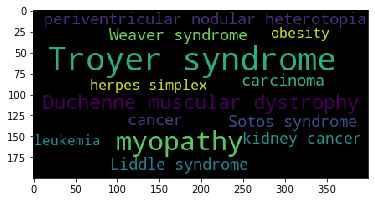

In [314]:
a = word_cloud(df_enrich, col_name='name', col_score='score')
plt.imshow(a)